# Module 2: Factor Models

In this module, we will explore linear factor models (LFMs). 

## Table of Contents:
&nbsp;&nbsp;0. [Motivation of Factor Models](#0)

&nbsp;&nbsp;1. [Introduction to Linear Factor Models](#1)


&nbsp;&nbsp;2. [Factor Model Setup and First Results](#2)   

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.0 [Model Setup](#2.0)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.1 [Plotting and Exploring the data](#2.1)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.1 [OLS Results](#2.2)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.2 [OLS Drawbacks](#2.3)


&nbsp;&nbsp;3. [Alternative ML Methods](#3)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.0 [LASSO Regression](#3.0)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.1 [LASSO with cross validation](#3.1)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2 [Elastic Net](#3.2)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.3 [Best Subset Regression](#3.3)



&nbsp;&nbsp;4. [Forecasting Expected Returns](#4)   

&nbsp;&nbsp;5. [Harvard 5 Factor Study Analysis for Multiple Assets](#5)   

&nbsp;&nbsp;6. [Additional Resources](#6)

&nbsp;&nbsp;7. [User Section](#7)

## 0. Motivation of Factor Models <a class="anchor" id="0"></a>

The factor approach began in the 1960s with the famous Fama-French research showing that certain categories of stocks outperformed (or underperformed) the general market indexes such as the S&P 500 over long historical periods.  This work extended Bill Sharpe’s single factor CAPM research (earning him a Nobel prize along with Harry Markowitz).   Putting these pieces together gave us the following three factors: 

 * Excess market returns (SP500 – T-Bills), 
 * Value – growth stocks, and 
 * Small minus large cap stocks.
 
We'll call these micro factor factors, since they are specific to firms rather than the economy as a whole.
 
At that time, financial researchers applied traditional OLS regression equations (covered in the next section) to estimate the importance of these factors (loadings) on the return of individual stocks.   

Subsequently, researchers have discovered and published dozens of papers on additional factors as candidates for inclusion in a systematic analysis when forming a portfolio of stocks.  Today, there are over 50 factors that have displayed patterns in return, and there is much attention to observing the state of these factors by firms such as MSCI and other providers of analytical services.   

As mentioned in the previous subsection, we have seen the shift into alternative investment categories by university endowments and more recently by large institutional investors including global pension plans and sovereign wealth funds. These funds have a hybrid nature in that they include multiple risk categories.  For instance, we will explore instruments which contain both interest rate risks and equity risks (during crash periods high yield bond funds generate losses due to bankruptcy and other default risks).  Other hybrids occur in private equity, various categories of hedge funds, real assets, levered debt funds, and so on. 

To untangle these complicated investments and in response to the major loss of capital by many investors in the 2008/09 crash period, financial researchers turned to risk factors for systematic investigation of the underlying risks at the asset allocation level. We call these macro-factors – as compared with the micro factors mentioned above.  But the goal is the same:  trace down the underlying risk factors when conducting a portfolio analysis.  Note that what we refer to as factors are equivalent to “features” in machine learning. In notebook five of this online course, we use of a large set of factors/features to estimate the probability of various market conditions over a future time-period – monthly in our example.   

The study of macro-factors has led to new methods in an asset allocation or Asset Liability Modeling (ALM).  Rather than describing each of these studies, we have chosen one study for our purposes. Here, we follow the work of Harvard University's endowment and their use of five factors: a) global equity, b) long term U.S. government bonds, c) high yield bonds, d) inflation hedging, and e) currency hedging.   The first three factors are most reasonable since they are surrogates for asset pricing models (earnings, risk free interest rates, and a risk premium).  The other two factors are driven by the importance of international investments by Harvard and the need to address inflation risks due to the linkage of spending by Harvard to future inflation.   

We will discuss a more systematic approach to estimating the factor loading and employing these loading when forecasting future expected returns for the assets within our portfolio model.  In particular, we will apply a regularized regression with a penalty term to shrink the loadings.  This shrinkage is motivated by the Stein result (paradox) since we are estimating the return for more than 2 asset categories. The best penalty value will be determined by cross validation which useses training and validation to estimate the penalty.

## 1. Introduction to Linear Factor Models <a class="anchor" id="1"></a>

To begin, let's introduce the basic linear factor model, and the estimator, Ordinary Least Squares (OLS).

The linear factor model can be written as follows.

\begin{equation*}
    y_t = {X_t}^T \beta + \epsilon_t
\end{equation*}

$t$ is used to index each observation. ${\bf y} = \{y_t\}$ is called the dependent variable for observation $t$ and the vector ${X_t}^T = (X_t^1, X_t^2, \dots, X_t^m)$ is called the set of factors (statisticians would call them independent or explanatory variables) for observation $t$. 

${\bf \beta} = (\beta_1,\dots,\beta_m)'$ are called the factor loadings. (Statisticians would call them the coefficients.)

As in most of finance, the dependent variable $y_t$ will the be the returns of some asset, and the independent variables will the the return of the factors.  We call this a linear factor model because we have assumed a linear relationship between the returns of the factors and the returns of the assets.

With historical data, the factor loadings ${\bf \beta}$ can be estimated via Ordinary Least Squares (OLS):

\begin{equation*} 
    \hat{\beta}^{\text{OLS}} = argmin_{\beta}\bigg\{\sum_{t=1}^{n} (y_t - {X_t}^T {\bf \beta})^2 \bigg\}.
\end{equation*}


Before we run the OLS estimation, let's first define our factors.

## 2. Factor Model Setup and First Results <a class="anchor" id="2"></a>

If $y_t$ represent an asset return at time t, the linear factor model can help us interpret the source of the asset return and attribute it to the factor returns.

In this example, we are interested in explaining the asset returns with a five-factor model:

1) World Equities: MSCI All World market capitalization weighted index.

2) 10 Year US Treasury: Return of 10 year US Treasury Bond

3) High Yield: BOFA Merrill Lynch Global High Yield Index

4) Inflation Protection: This is a "style" factor that considers the difference between real and nominal returns, thus balances the need for both.  It's the return of the TIPS bond minus the a weighted average of Treasury Bonds.

5) Currency Protection: This is also an exchange rate factor, capturing the value of the dollar versus a basket of foreign currencies.

As mentioned before, the first three factors can be thought of as surrogates for asset pricing models (earnings, risk free interest rates, and a risk premium).  The other two factors are driven by the importance of international investments (currency protection) and the need to understand inflation effects (inflation protection).   


### 2.0 Model Setup <a class="anchor" id="2.0"></a>
For the first step, let's import necessary packages and define our functions (for later use):


In [1]:
#import all the necessary packages
import numpy as np #for numerical array data
import pandas as pd #for tabular data
import matplotlib.pyplot as plt #for plotting purposes

from sklearn.metrics import r2_score

%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import importlib as imp

import FactorModelLibForMOOC as fm #the code that wraps around the sikitlearn implementations
import config_demo_final as config


import warnings
warnings.filterwarnings('ignore')

Next, read our data and check the assets/factors we have:

In [2]:
all_data = pd.read_csv(config.dataPath)
all_data[config.dateName] = pd.to_datetime(all_data[config.dateName])
all_data = all_data[all_data['Date'] <= '2014-12-01'].copy() ## dropping data where there are nulls

### 2.1 Plotting and Exploring the data <a class="anchor" id="2.1"></a>

First things first, let's look at the data.

In [3]:
all_data[['Real Estate'] + config.factorName].head(5)

,Real Estate,World Equities,10-year US Treasuries,High Yield,Inflation Protection,Currency Protection
0,-0.014847,-0.020349,0.022922,0.032048,0.006524,-0.003404
1,0.032460,0.010680,0.030014,0.013531,-0.038375,-0.020587
2,-0.005961,0.045804,0.007195,0.025871,-0.023184,-0.042060
3,0.002259,0.036372,0.016973,0.030836,-0.003600,-0.015827
4,0.045025,0.011040,0.054900,0.006743,-0.054282,0.009121


Next, determine the time increment for our data

In [4]:
fm.data_time_periods(all_data, config.dateName)

'monthly'

In [5]:
startDate = all_data[config.dateName].min()
endDate = all_data[config.dateName].max()

Let's get more specific.  Let's plot our data over time

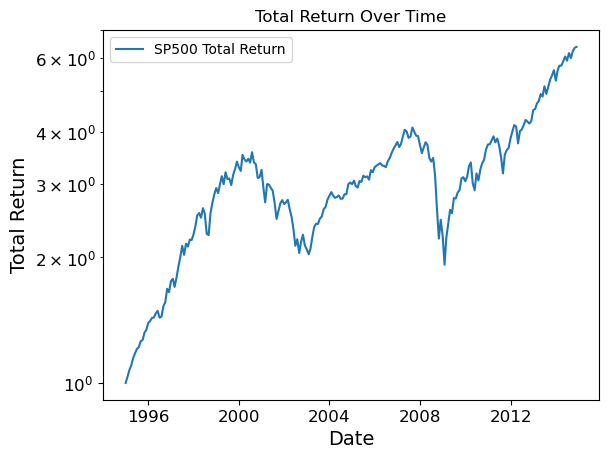

In [6]:
name = 'SP500 Total Return'
fm.plot_returns(all_data, name, flag='Total Return')

As a sanity check, find the months where the monthly return of US equities were the lowest.

In [7]:
pd.options.display.float_format = "{:,.3f}".format #This rounds the display output to 3 decimals
all_data.sort_values('SP500 Total Return').head(3)

,Date,World Equities,10-year US Treasuries,High Yield,Inflation Protection,Currency Protection,U.S. Equity,SP500 Total Return,S&P 500,International Equity,U.S. Treasury 20 years,Corporate Bond,Real Estate,Commodity,TIPS
165,2008-10-01,-0.194,-0.029,-0.084,-0.058,0.087,-0.173,-0.166,-0.168,-0.205,-0.036,-0.070,-0.312,-0.295,-0.087
166,2008-11-01,-0.132,0.085,0.075,-0.078,0.006,-0.163,-0.152,-0.072,-0.112,0.144,0.045,-0.337,-0.176,0.007
169,2009-02-01,-0.131,-0.002,0.033,-0.018,0.028,-0.148,-0.148,-0.106,-0.127,-0.004,-0.019,-0.269,-0.097,-0.020


All three months were part of [The Great Financial Crisis](https://en.wikipedia.org/wiki/Financial_crisis_of_2007%E2%80%932008).

### 2.2 OLS Regression <a class="anchor" id="2.2"></a>

Now let's return to factor models.  Building a factor module is equivalent to solving for the factor loadings defined in part 1.  Ordinary Least Squares (OLS) regression is the simplest way.

As we mentioned in part 1, OLS regression is equivalent to solving the following optimization problem

\begin{equation*} 
    \hat{\beta}^{\text{OLS}} = argmin_{\beta}\bigg\{\sum_{t=1}^{n} (y_t - {X_t}^T {\bf \beta})^2 \bigg\}
\end{equation*}

In our notation, n in the number of data points.  In this case, OLS regression has a closed form solution.

\begin{equation*} 
    \hat{\beta}^{\text{OLS}} = ({\bf X}^\intercal {\bf X})^{-1} {\bf X}^\intercal{\bf Y}
\end{equation*}

Where ${\bf Y}$ is the vector representation of $y_t$, and ${\bf X}$ is the matrix representation of $X_t$

Let's take a second to look at, $\hat{\beta}$, the factor loadings.  What do they mean?  They represent the effect on the dependent variable (in this case, the asset return) associated with movement in the underlying factor.

In this course we will be using the sikitlearn package to build models.  But since we have a closed form solution, let's check that the closed form solution gives the same answer as scikit-learn.

In [8]:
# Linear Regression (OLS)
Factors = all_data[config.factorName].values
Assets = all_data[config.assetName].values

Asset_RE = Assets[:,0]
Factors_ones = np.concatenate((np.ones((all_data.shape[0],1)),Factors),axis=1)
theory_beta = np.linalg.inv(Factors_ones.T.dot(Factors_ones)).dot(Factors_ones.T).dot(Asset_RE)
print('Dependent variable is SP500 Total Return')
print('Historical Timeperiods ' +  fm.num_to_month(startDate.month) +  " " + str(startDate.year) + " "
      + fm.num_to_month(endDate.month) +  " " + str(endDate.year))
opt = dict()
opt['name_of_reg'] = 'theory_beta'
fm.display_factor_loadings(theory_beta[0], theory_beta[1:], config.factorName, opt)

Dependent variable is SP500 Total Return
Historical Timeperiods January 1995 December 2014
             Intercept  World Equities  10-year US Treasuries  High Yield  \
theory_beta      0.001           1.021                  0.128      -0.004   

             Inflation Protection  Currency Protection  
theory_beta                -0.011                0.397  


In [9]:
#Linear Regression via Scikit-learn
options = fm.create_options()
options['name_of_reg'] = 'sikit-learn OLS'
fm.linear_regression(all_data, 'SP500 Total Return', config.factorName, options)

Dependent Variable is SP500 Total Return
Time period is between January 1995 to December 2014 inclusive   
                 Intercept  World Equities  10-year US Treasuries  High Yield  \
sikit-learn OLS      0.001           1.021                  0.128      -0.004   

                 Inflation Protection  Currency Protection  
sikit-learn OLS                -0.011                0.397  


Indeed it does

### 2.3 OLS Drawbacks <a class="anchor" id="2.3"></a>

Unfortunately, OLS is notoriously unstable.  Namely, the factor loadings it produces do not work well on future data.
It does not generalize well to future data for a couple of reasons.  

First, there generally is high correlation among the factors, (which we avoid here).  This leads to large standard errors on the factor loadings.  Historically, ridge regression was used to deal with this, which we will briefly mention later.

We should also stress the issue of overfitting when the number of factors grealy exceeds the number of asset categories.  This issue is critical with the expansion of available data sources.

Instead here, we'll discuss more recent ideas for estimating factor loadings.

As a secondary point, OLS has no regime awareness.  Factor loadings are not constant over time.  If we could estimate regime specific factor loadings, these loadings would be more stable.

### Factor Correlation

In this case, we do not have high correlation between the Bond indices (Treasury and High Yield).  We do have a high (negative) correlation between the Inflation Protection and the 10-year US Treasury.

We do not have high correlation between these factors, thus ridge regression is not necessary.

In [10]:
all_data[config.factorName].corr()

,World Equities,10-year US Treasuries,High Yield,Inflation Protection,Currency Protection
World Equities,1.000,-0.176,0.308,0.332,-0.528
10-year US Treasuries,-0.176,1.000,0.131,-0.616,-0.140
High Yield,0.308,0.131,1.000,0.005,-0.185
Inflation Protection,0.332,-0.616,0.005,1.000,-0.209
Currency Protection,-0.528,-0.140,-0.185,-0.209,1.000


### Regime Dependence

Here we show that the OLS estimator depends greatly on the time period.  First, we will pick different time periods and run the OLS regression, and show the factor loading change substantially.  To formalize this idea, we will filter our data into two different regimes.  The first regime "normal", will be months where US Equities had a positive monthly return.  The second, "crash" will be months where US Equities had a negative return.  These are crude approximations, but even with this crude definition OLS will gives substantially different factor loadings.

In a future module we will refine our definition of crash periods using LASSO.

Here are the factor loadings using the full data set, the normal regime, and the crash regime.

In [11]:
options = fm.create_options()
options['name_of_reg'] = 'OLS full data'
options['return_model'] = False
fm.linear_regression(all_data, 'SP500 Total Return', config.factorName, options)

Dependent Variable is SP500 Total Return
Time period is between January 1995 to December 2014 inclusive   
               Intercept  World Equities  10-year US Treasuries  High Yield  \
OLS full data      0.001           1.021                  0.128      -0.004   

               Inflation Protection  Currency Protection  
OLS full data                -0.011                0.397  


First we run the "Normal" regime OLS regression.

In [12]:
options = fm.create_options()
normal_data = all_data[all_data['SP500 Total Return'] > 0].copy()
options['name_of_reg'] = 'OLS Normal'
options['return_model'] = False
fm.linear_regression(normal_data, 'SP500 Total Return', config.factorName, options)

Dependent Variable is SP500 Total Return
Time period is between January 1995 to December 2014 inclusive   
            Intercept  World Equities  10-year US Treasuries  High Yield  \
OLS Normal      0.007           0.913                  0.201       0.025   

            Inflation Protection  Currency Protection  
OLS Normal                -0.003                0.388  


Next we perform the analysis on crash months.

In [13]:
options = fm.create_options()
crash_data = all_data[all_data['SP500 Total Return'] <= 0].copy()
options['name_of_reg'] = 'OLS Crash'
options['return_model'] = False
fm.linear_regression(crash_data, 'SP500 Total Return', config.factorName, options)

Dependent Variable is SP500 Total Return
Time period is between July 1996 to September 2014 inclusive   
           Intercept  World Equities  10-year US Treasuries  High Yield  \
OLS Crash     -0.009           0.822                  0.065      -0.004   

           Inflation Protection  Currency Protection  
OLS Crash                 0.159                0.229  


Even with a crude definition of a "crash" regime we have isolated different factor loadings.  During "Normal" periods, the S&P500 has a loading on the 10-year US Treasury, but during crash periods, it almost disapears.

The currency protection effect decreases during crash periods.

For now, we'll ignore the regime dependence and return to it in a later module.

### Baseline OLS Model

Even so, for the sake of comparison, lets build a baseline OLS model on our training set, setting data aside for future testing.

Our breakpoint will be December 2012

In [14]:
train = all_data[(all_data['Date'] <= '2012-12-01') & (all_data['Date'] >= '1997-03-01')].copy()
test = all_data[all_data['Date'] > '2012-12-01'].copy()

In [15]:
options = fm.create_options()
options['name_of_reg'] = 'OLS full data'
options['return_model'] = True
ols_model_train = fm.linear_regression(train, 'SP500 Total Return', config.factorName, options)

Dependent Variable is SP500 Total Return
Time period is between March 1997 to December 2012 inclusive   
               Intercept  World Equities  10-year US Treasuries  High Yield  \
OLS full data     -0.000           1.007                  0.132      -0.000   

               Inflation Protection  Currency Protection  
OLS full data                 0.058                0.374  


## 3 Alternative ML Methods <a class="anchor" id="3"></a>

Now that we have motivated the drawbacks of OLS, we can move to modern machine learning techniques.  We'll cover two classes of techniques, penalized regressions and constrained regressions.

Penalized regressions are exactly what they sound like.  We introduce a penalty to penalize factor loadings in order to shrink the factor loadings.  This is in keeping with previously mentioned Stein paradox.  In this context, the Stein paradox states that when estimating more than 3 parameters, OLS regression leads to larger mean squared error than other methods.  In short, we will introduce a penalty as a way to decrease overall error.

LASSO regression isthe simplest version of regularized regression.  Here we add a penalty term to the optimization problem to penalize the model's complexity.  For the sake of intuition, imagine if we could penalize the number of non-zero factor loadings we add to the model.  In that instance we would expect that the model would only consider the variables that really influence Y, and ignore the noise variables.  LASSO regression (defined below) does exactly that.

The second method is the Elastic Net, which is the combination of two different penalizations, which we discuss later.

The third method, "best subset selection", is an example of a constrained regression.  Conceptually, the optimization problem is directly constrained to only allow for a certain number of non-zero coefficients.  Put another way, best x-subset regression says "I seek the best model where I can at maximum use x variables."

### 3.0 LASSO Regression <a class="anchor" id="3.0"></a>

We define LASSO regression as the following optimization problem.

As before, n is the number of data points, and m is the number factors.

\begin{equation*} 
    {\hat{\beta}}^{\text{LASSO}} = argmin_{\beta}\bigg\{\sum_{t=1}^{n} (y_t - X_t^T \beta)^2 + \lambda \sum_{j=1}^{m}|\beta_j| \bigg\}
\end{equation*}

Note that it is the same as the OLS regression, but with a second penalty term.  As stated above, it directly penalizes the use of non zero coefficients and can be shown to set factor loadings to zero.  If you want to learn more about the theoretical properties of LASSO regression, the text book [Elements of Statistical Learning](https://web.stanford.edu/~hastie/ElemStatLearn/) covers the method in detail.

We'll make one note here, that the penalty is a "L1 Norm".  We penalize the sum of the absolute value of the factor loadings.  This means that any non-zero factor loading (i.e non-zero coefficient) is penalized in this model.

Why do we do this?  Well, we're actively adding a penalty to shrink our factor loadings.  Alternatively, one can think of this as an application of Stein's result that penalized estimators can outperform OLS estimators.

The shrinkage parameter $\lambda$ is called a hyperparameter which you need to choose via the cross validation procedure.  Sikit-learn doesn't use $\lambda$ it uses $\alpha$.  Since we use $\alpha$ for other things in this course, we'll define it as $\hat{\lambda}$ or adjusted lambda.

\begin{equation*}
    {\frac{\lambda}{2*n} = \hat{\lambda}}
\end{equation*}

Where $n$ is the number of data points.  For now, let's arbitrarily pick $\hat{\lambda} = .00001$

In general, you scale the factors so all Factors to the same standard deviation.  Since LASSO penalizes the size of the coefficient, which is related to the variance of the factor, you do not want to arbitrarily penalize factors more for having smaller variances (or vice versa).  We won't do this in this module for simplicity's sake, and to aid with interpretability of our final model.

So what happens to the model if we introduce a small $\hat{\lambda}$ value?  It penalizes the factors, setting some Factor Loadings to zero.

To build intuition, let's try different values of $\hat{\lambda}$, and see what happens.

For instance, the following codeblock calculates the LASSO model with $\hat{\lambda}$ =.00001

In [16]:
options = fm.create_options_lasso()
options['lambda_hat'] = .00001
options['print_loadings'] = True
options['name_of_reg'] = 'LASSO Regression with small Lambda'
fm.lasso_regression(train, 'SP500 Total Return', config.factorName, options)

Dependent Variable is SP500 Total Return
Time period is between March 1997 to December 2012 inclusive   
lambda_hat = 1e-05
                                    Intercept  World Equities  \
LASSO Regression with small Lambda      0.000           0.990   

                                    10-year US Treasuries  High Yield  \
LASSO Regression with small Lambda                  0.063       0.000   

                                    Inflation Protection  Currency Protection  
LASSO Regression with small Lambda                 0.000                0.308  


What happens with a larger lambda?  Well, it can set almost every factor loading to zero.

In [17]:
options = fm.create_options_lasso()
options['lambda_hat'] = .001 #The input alpha value
options['print_loadings'] = True
options['name_of_reg'] = 'LASSO Reg with large Lambda'
fm.lasso_regression(train, 'SP500 Total Return', config.factorName, options)

Dependent Variable is SP500 Total Return
Time period is between March 1997 to December 2012 inclusive   
lambda_hat = 0.001
                             Intercept  World Equities  10-year US Treasuries  \
LASSO Reg with large Lambda      0.003           0.551                 -0.000   

                             High Yield  Inflation Protection  \
LASSO Reg with large Lambda       0.000                 0.000   

                             Currency Protection  
LASSO Reg with large Lambda               -0.000  


LASSO may not only shrink as desired, but given too high a lambda, it may also discard valuable factors, as demonstrated above.

This leaves the central question with LASSO regression.  What is the appropriate value of $\lambda$, and by extension, what is the appropirate set of factors to include?

### 3.1 Cross Validation  <a class="anchor" id="3.1"></a>

In practice, cross validation selects the correct shrinkage parameter $\lambda$, or in our case $\hat{\lambda}$'s value.  Cross validation tests multiple different values of $\lambda$ and selects the "best one."  We will not give a formal definition of cross-validation here, and instead we will give a heuristic.

First, break the training set into $k$ sections called folds, and define a list of N trial $\lambda$ values.  Take one of the folds, put it to the side and label it validation.  Combining the remaining $k-1$ folds, build a model with each candidate $\lambda$.  This gives you N models.  Calculate the mean squared error of each model on validation fold.  Then, pick the next fold to use a validation.  Again, build the N different models, one for each $\lambda$, and again calculate the mean squared errors on the new validation fold.  Do this $k$ times, one for each of the original folds.

At the end of this, you will have built $n*k$ models.  For each value of $\lambda$ you will have $k$ out of sample errors. 

Finally pick the $\lambda$ which minimizes the average error across across the samples.

Importantly, once you have picked the optimal lambda, you then go build one final model with all of the data and that value of $\lambda$.  That is your final model!

There is not a consensus of how many folds to pick, but 5 will work for our purposes.

Below we use cross validation to pick the optimal lambda value for lasso.

In [18]:
options = fm.create_options_cv_lasso()
options['name_of_reg'] = 'CV Lasso'
options['max_lambda_hat'] = .001 #This specifies the maximum Alpha value tested by cross validation, minimum value is zero
options['return_model'] = True
options['n_folds'] = 5 #This states the number of folds
lasso_model_train = fm.cross_validated_lasso_regression(train, 'SP500 Total Return', config.factorName, options)

Dependent Variable is SP500 Total Return
Time period is between March 1997 to December 2012 inclusive   
Best lambda_hat = 1.6667957547420788e-05
          Intercept  World Equities  10-year US Treasuries  High Yield  \
CV Lasso      0.000           0.977                  0.036       0.000   

          Inflation Protection  Currency Protection  
CV Lasso                -0.000                0.272  


### 3.2 Elastic Net <a class="anchor" id="3.2"></a>

Now that we've discussed cross validation the LASSO regression, let’s talk about penalized regressions more generally.  One can mix and match penalized regressions to create regressions with specific properties.  For instance, we know from literature that LASSO regression can be used for variable selection.

Here we briefly mention Ridge regression, which is an even older version of penalized regression.  It also shrinks factor loadings, but does not set them to zero.  Ridge's claim to fame is that it shrinks the coefficients of highly correlated factors.  This can be useful if you have many versions of roughly the same factor. Instead of finding the "best version" of the factor, you may want to use a average.

More recently, practitioners combined the LASSO and Ridge, called an Elastic Net, and it can provide the benefits of both methods.

Importantly, the ridge regression penalty is most valuable when the factors are highly correlated.  In this example the factors are not highly correlated.  We cover the method for completeness.

As with the previous cross validation sample, once we have selected the optimal values of $\lambda_1$ and $\lambda_2$ we then build our final model on the entire training set, with the selected $\lambda_1$ and $\lambda_2$.

Again, for our notation, n equals the number of data points, and m is the number of factors.

\begin{equation*} 
    {\hat{\beta}}^{\text{LASSO}} = argmin_{\beta}\bigg\{\sum_{t=1}^{n} (y_t - X_t^T \beta)^2 + \lambda_1 \sum_{j=1}^{m}|\beta_j| \bigg\}
\end{equation*}

\begin{equation*} 
    {\hat{\beta}}^{\text{Ridge}} = argmin_{\beta}\bigg\{\sum_{t=1}^{n} (y_t - X_t^T \beta)^2 + \lambda_2||\beta||_2^2 \bigg\}
\end{equation*}

\begin{equation*} 
    {\hat{\beta}}^{\text{Elastic Net}} = argmin_{\beta}\bigg\{\sum_{t=1}^{n} (y_t - X_t^T \beta)^2 + \lambda_1 \sum_{j=1}^{m}|\beta_j| + \lambda_2||\beta||_2^2 \bigg\}
\end{equation*}

In our notation, $||\beta||_2^2$ indicates the two norm of the vector $\beta$.  In English, this means we penalize the sum of the squares of the factor loadings.

In scikit-learn, they write the Elastic Net slightly differently.

\begin{equation*} 
    {\hat{\beta}}^{\text{Elastic Net}} = argmin_{\beta}\bigg\{\sum_{t=1}^{n} (y_t - X_t^T \beta)^2 + \hat{\lambda}*\text{l1_ratio}\sum_{j=1}^{m}|\beta_j| + .5*\hat{\lambda}*(1-\text{l1_ratio})||\beta||_2^2 \bigg\}
\end{equation*}

Here, we have two shrinkage parameters $\hat{\lambda}$ and $\text{l1_ratio}$.  $\hat{\lambda}$ now controls the amount of penalization we apply, and $text{l1_ratio}$ controls the amount of penalization comes from LASSO vs Ridge.

Let's run Elastic Net and see if we get different results.

In [19]:
options = fm.create_options_cv_elastic_net()
options['name_of_reg'] = 'CV Elastic Net'
options['max_lambda_hat'] = .01
options['n_folds'] = 5
options['return_model'] = True
el_model_train = fm.cross_validated_elastic_net_regression(train, 'SP500 Total Return', config.factorName, options)

Dependent Variable is SP500 Total Return
Time period is between March 1997 to December 2012 inclusive   
Best lambda_hat = 1.759702749929848e-05
Best l1 ratio = 0.9378947894736842
                Intercept  World Equities  10-year US Treasuries  High Yield  \
CV Elastic Net      0.000           0.976                  0.036       0.000   

                Inflation Protection  Currency Protection  
CV Elastic Net                -0.000                0.271  


The results are almost identical.  Only the currency protection factor loading differes slightly and by less than 1\%.

### 3.3 Best Subset Regression <a class="anchor" id="3.3"></a>

Penalized regressions are not the only type of regression we can run.  We can also run constrained regressions!  Let's define an intuitive constrained regression called "Best Subset Regression".  It's name is exactly what it sounds like.  It attempts to find the linear model subject to the constraint that only "x" factor loadings can be nonzero.  In this case, "x" is an integer the user defines.

Formally, we set can define the best subset regression as follows:
Let $\textbf{z}$ be a vector of binary variables.  A binary variable is a variable that can only be a zero or a 1. Let $ M $ be a very large number.  What is "large", well, it should be much larger than the largest of the factor laodings.  Since our factor loadings are generally around 1 in size, M is set as a default to 1000.

Let $ \text{total_vars} $ be the number of factors considered and $ \text{max_vars} $ be the number max number of factors allowed in the final model.

\begin{equation*} 
    {\hat{\beta}}^{\text{Best Subset}} = argmin_{\beta}\bigg\{\sum_{t=1}^{n} (y_t - X_t^T \beta)^2 \bigg\}.
\end{equation*}

\begin{equation*} 
    \sum_{i=1}^{\text{max_vars}} z_i \leq \text{max_vars,}  \hspace{2mm} Mz + \beta \geq 0 \text{  and  } \beta \leq Mz \text{  ,  } \textbf{z } \text{ binary}
\end{equation*}

In short, we are using the vector z to keep track of which factor loadings the model picks to be non-zero.  The elements of z can only be zero or 1.  So the first constraint (on the left) says that you can have at maximum only max_vars elements of z equal to 1.  The next two constraints enforce the condition that if an element of z is equal to 0, then the corresponding factor loading in $\beta$ must be equal to zero.  The second constraint says that if an element of z is equal to zero, then the corresponding element of $\beta$ must be less than or equal to zero.  Similarly, the third constraint says that if an element of z is equal to zero, the corresponding element of $\beta$ must be greater than or equal to zero.  Combined, those two constraints imply that the corresponding element of $\beta$ must be equal to zero.  If the element of z is equal to 1, then the constraints say the corresponding element of $\beta$ is between -M and M.  If M is large enough, this constraint is not binding.

In this notebook we'll call the "best_subset_regression" function from the library FactorModelLibForMOOC which has already coded this function.  If you are intersted in how the function is coded, refer to the library FactorModelLibForMOOC.  The function "best_subset_regression" uses the cvxpy library to build the model.



Let's run the Best Subset regression with with maxVars=2

In [20]:
options = fm.create_options_best_subset()
options['max_vars'] = 2
options['name_of_reg'] = 'Best Subset with maxVars = 2'
fm.best_subset_regression(train, 'SP500 Total Return', config.factorName, options)

Dependent Variable is SP500 Total Return
Time period is between March 1997 to December 2012 inclusive   
Max Number of Non-Zero Variables is 2
                              Intercept  World Equities  \
Best Subset with maxVars = 2      0.001           0.919   

                              10-year US Treasuries  High Yield  \
Best Subset with maxVars = 2                  0.000       0.000   

                              Inflation Protection  Currency Protection  
Best Subset with maxVars = 2                 0.000                0.000  


Of course you can vary the number non-zero coeficients.  Let's try maxVars=3.

In [21]:
options = fm.create_options_best_subset()
options['max_vars'] = 3
options['return_model'] = True
options['name_of_reg'] = 'Best Subset with maxVars = 3'
best_subset_3 = fm.best_subset_regression(train, 'SP500 Total Return', config.factorName, options)

Dependent Variable is SP500 Total Return
Time period is between March 1997 to December 2012 inclusive   
Max Number of Non-Zero Variables is 3
                              Intercept  World Equities  \
Best Subset with maxVars = 3      0.001           0.919   

                              10-year US Treasuries  High Yield  \
Best Subset with maxVars = 3                  0.000       0.000   

                              Inflation Protection  Currency Protection  
Best Subset with maxVars = 3                 0.000                0.000  


One might ask, why don't we always use best subset selection?  After all, it seems the most direct way to pick the best n variable model.  Well, one reason is because it's a mixed integer linear program.  The constraint on $\textbf{z}$ makes the system hard to solve for large numbers of variables.  While some recent work has been done to make the optimization problem feasible using hundreds of variables, LASSO (and other methods) works for potentially thousands of factors.

## 4 Forecasting Expected Returns <a class="anchor" id="4"></a>

Let's compare what our different models do.  Let's look at the coefficients, and how well they explain the returns of real estate on our testing set, and what they forecast for future expected returns.


Below are our estimates for the future expected returns of the individual factors.  These are called capital market assumptions, and there is much attention to estimating these values in an asset allocation or asset liability study.  If we're looking at hybrid products, it materially simplifies the problem if we can use the forward looking returns assumptions for a small set of factors to estimate the returns of a large number of other assets.

For now, we'll use the following assumptions.

 * Global Equities: 8%
 * 10-Year Treasury Bonds: 2%
 * High Yield Bonds: 5%
 * Inflation Protection: -.3%
 * Currency Protection: 0%

How do we turn this into an annualized expected return?  Simple, we take the (monthly) version of our yearly factor returns, and use them as inputs to our model.  Then we multiply by 12 (to annualize).

In [22]:
models = [ols_model_train, lasso_model_train, el_model_train, best_subset_3]

comparison = pd.DataFrame(np.zeros((4, 7)), columns=['Intercept'] + config.factorName + 
                          ['Implied Expected Return S&P 500 (Annual)'])
expected_returns = pd.DataFrame(np.array([[.08/12, .02/12, .05/12, -.003/12, 0/12]]), columns=config.factorName)

for i in range(len(models)):
    model = models[i]
    comparison.loc[i,'Intercept'] = model.intercept_
    comparison.loc[i, config.factorName] = model.coef_
    comparison.loc[i, 'Implied Expected Return S&P 500 (Annual)'] = 12*model.predict(expected_returns)
    
comparison.index = ['OLS', 'LASSO', 'Elastic Net', 'Best Subset']

In [23]:
comparison

,Intercept,World Equities,10-year US Treasuries,High Yield,Inflation Protection,Currency Protection,Implied Expected Return S&P 500 (Annual)
OLS,-0.000,1.007,0.132,-0.000,0.058,0.374,0.078
LASSO,0.000,0.977,0.036,0.000,-0.000,0.272,0.082
Elastic Net,0.000,0.976,0.036,0.000,-0.000,0.271,0.082
Best Subset,0.001,0.919,0.000,0.000,0.000,0.000,0.080


Let's take the LASSO model as our "final forecast" (as they did in the Harvard Study).  We have the expected return of the S&P500 to be 8.2%.

Does this prediction work well out of sample?  We can use the r2_score function (from sklearn) to calculate the error on the testing set from our model.  

As it turns out, all 4 methods do generally well on this series.  In general, if you have the returns of World Equities to explain the returns of S&P500, your explanitory regression will do well.

Below is the error on the testing set (2013-2014).

In [24]:
models = [ols_model_train, lasso_model_train, el_model_train, best_subset_3]
predictions = pd.DataFrame(np.zeros((4,1)), columns=['R^2 on Testing Set'])

for i in range(len(models)):
    model = models[i]
    predictions.loc[i, 'R^2 on Testing Set'] = r2_score(test['SP500 Total Return'],
                                                        model.predict(test[config.factorName]))
predictions.index = ['OLS', 'LASSO', 'Elastic Net', 'Best Subset']

In [25]:
predictions

,R^2 on Testing Set
OLS,0.856
LASSO,0.858
Elastic Net,0.858
Best Subset,0.804


## 5 Harvard 5 Factor Study Analysis for Multiple Assets <a class="anchor" id="4"></a>

Now that we've thoroughly reviewed the analysis for 1 asset class.  Let's replicate (part) of the Harvard 5 factor study, with a larger set of asset.  For each asset defined below, we run the 5 fold cross validated LASSO regression and calculate the factor loadings and intercept.  Let's see if we can generate any insights.

1) US Equities: Total Return of S&P 500

2) International Equities: Total Return of MSCI World EX US Index

3) Treasury Bond 20 Year: Return of 20 Year US Treasury Bond

4) Corporate Bonds: BofA Merrill Lynch US Corp Master Total Return Index

5) Real Estate: US-DS Real Estate Total Return Index

6) Commodity: GSCI Total Return Minus T-bill

7) TIPS: Barclays US Treasury Inflation-Linked Bond Index (same index as when calculating inflation protection)

In [26]:
names = config.assetName

expected_returns = pd.DataFrame(np.array([[.08/12, .02/12, .05/12, -.003/12, 0/12]]), columns=config.factorName)

factor_matrix = pd.DataFrame(np.zeros((4, 7)), columns=['Intercept'] + config.factorName + 
                          ['Implied Expected (Annual) Return'])

for i in range(len(names)):
    options = fm.create_options_cv_lasso()
    options['name_of_reg'] = 'CV Lasso'
    options['max_lambda_hat'] = .001 #This specifies the maximum Alpha value tested by cross validation, minimum value is zero
    options['return_model'] = True
    options['print_loadings'] = False
    options['n_folds'] = 5 #This states the number of folds
    data = all_data[[names[i]] + config.factorName + ['Date']].copy()
    data = data[(data['Date'] >= '1997-03-01') & (data['Date'] <= '2012-12-01')].copy()
    data = data.dropna()
    model = fm.cross_validated_lasso_regression(data, names[i], config.factorName, options)
    
    factor_matrix.loc[i,'Intercept'] = model.intercept_
    factor_matrix.loc[i, config.factorName] = model.coef_
    factor_matrix.loc[i, 'Implied Expected (Annual) Return'] = 12*model.predict(expected_returns)
    
factor_matrix.index = names

In [27]:
factor_matrix

,Intercept,World Equities,10-year US Treasuries,High Yield,Inflation Protection,Currency Protection,Implied Expected (Annual) Return
SP500 Total Return,0.000,0.977,0.036,0.000,-0.000,0.272,0.082
International Equity,0.000,0.932,-0.085,0.023,-0.018,-0.323,0.077
U.S. Treasury 20 years,-0.000,-0.000,1.340,0.026,-0.000,0.098,0.025
Corporate Bond,0.002,0.081,0.566,0.074,0.234,-0.004,0.039
Real Estate,0.007,0.531,0.000,0.000,0.000,-0.000,0.123
Commodity,0.003,0.215,0.000,-0.057,0.841,-0.992,0.043
TIPS,0.000,0.002,0.958,0.000,0.939,-0.000,0.019


What can we say about the Factors.  S&P 500 is basically world equities, but with a small loading on US Treasuries, and a positive loading on currency protection.  International Equities is a lower volatility version of World Equities with a negative loading on currency protection.  So diversifying across both makes you flat across your currency exposure, as expected.

The 20 Year Treasury Bond is essentially a levered version of the 10 year.  The Corporate Bond Index is a combination of the 10-year Treasury Bond + inflation protection.

Now that we have a methodology for expected returns, all we need is a measure of the covariance between the assets, and we are ready to run the traditional Markowitz mean variance portfolio construction to solve for the optimal risk adjusted portfolio.

In the next module, we go over how to do just that.

## 5 Additional Resources <a class="anchor" id="5"></a>

For more information on the Harvard study.  [The paper can be found here](https://dash.harvard.edu/bitstream/handle/1/27716504/47611405.pdf?sequence=1)

For more information on Lasso Regression, one can refer to [wikipedia](https://en.wikipedia.org/wiki/Lasso_(statistics)) or the original paper [here](http://statweb.stanford.edu/~tibs/lasso.html)

If you want to learn more about best subset verses LASSO verses and other variable selection techniques, we encourage you to skim through [this paper](http://www.stat.cmu.edu/~ryantibs/papers/bestsubset.pdf)

If you would like to learn more about the advantages of Elastic Net verses LASSO regression, please refer to [this paper](https://web.stanford.edu/~hastie/Papers/B67.2%20%282005%29%20301-320%20Zou%20&%20Hastie.pdf)

Finally, for a comprehensive overview of the statistical properties of all of these methods, one should review [this book](https://web.stanford.edu/~hastie/ElemStatLearn/)

## 6 User Section <a class="anchor" id="6"></a>
In this section, we provide a space for the user to run their own analysis.  Modifying this section also allows the student to answer the practice questions at the end of the module.

Instructions:
   * Go to the file config.py and turn the demo variable to False
   * Change the following variables
      * dataPathUser: path to data you wish to analyse, must be in CSV format
      * factorNameUser: Make a list of the factors you wish to consider.  The elements of this list must be columns in the csv file located at dataPathUser
      * assetNameUser: string, names the asset you wish to calculate factor loadings with
      * dateNameUser: defines the date column in your data set
  * Click on Cell -> Run All Below, and the notebook will re-run this section given the user's specifications
      
This section runs OLS, LASSO, and Best Subset Regression.  Feel free to compare and contrast any results you get in this section to the results from the above notebook

In [28]:
imp.reload(config)
imp.reload(fm)
if(config.isDemo == False):
    #Load in Data
    data_user = pd.read_csv(config.dataPathUser)
    data_user[config.dateNameUser] = pd.to_datetime(data_user[config.dateNameUser])
    data_user = data_user[(data_user[config.dateNameUser] >= config.startDateUser)
                       & (data_user[config.dateNameUser] <= config.endDateUser)]

## Print Cumulative Returns of the Data

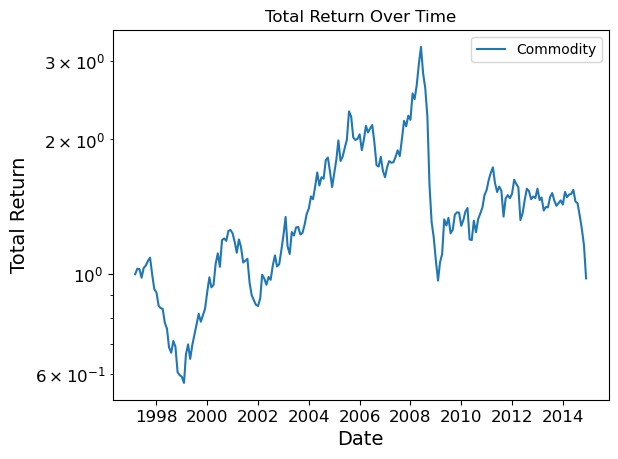

In [29]:
fm.plot_returns(data_user, config.assetNameUser, flag='Total Return')

## OLS

In [37]:
if(config.isDemo==False):
    options_user = fm.create_options()
    options_user['print_loadings'] = True
    options_user['name_of_reg'] = 'OLS for ' + str(config.assetNameUser)
    fm.linear_regression(data_user, config.assetNameUser, config.factorNameUser, options_user)

Dependent Variable is Commodity
Time period is between March 1997 to December 2014 inclusive   
                   Intercept  World Equities  10-year US Treasuries  \
OLS for Commodity      0.001           0.182                  0.152   

                   High Yield  Inflation Protection  Currency Protection  
OLS for Commodity      -0.156                 1.276               -1.114  


In [54]:
model = fm.linear_regression(data_user, config.assetNameUser, config.factorNameUser, options_user)

Dependent Variable is Commodity
Time period is between March 1997 to December 2014 inclusive   
                   Intercept  World Equities  10-year US Treasuries  \
OLS for Commodity      0.001           0.182                  0.152   

                   High Yield  Inflation Protection  Currency Protection  
OLS for Commodity      -0.156                 1.276               -1.114  


In [55]:
expected_returns = pd.DataFrame(np.array([[.08/12, .02/12, .05/12, -.003/12, 0/12]]), columns=config.factorName)
models = [ols_model_train]
comparison = pd.DataFrame(np.zeros((1, 7)), columns=['Intercept'] + config.factorName + 
                          ['Implied Expected Return S&P 500 (Annual)'])
for i in range(len(models)):
    model = models[i]
    comparison.loc[i,'Intercept'] = model.intercept_
    comparison.loc[i, config.factorName] = model.coef_
    comparison.loc[i, 'Implied Expected Return S&P 500 (Annual)'] = 12*model.predict(expected_returns)
    
comparison.index = ['OLS']
comparison

,Intercept,World Equities,10-year US Treasuries,High Yield,Inflation Protection,Currency Protection,Implied Expected Return S&P 500 (Annual)
OLS,-0.000,1.007,0.132,-0.000,0.058,0.374,0.078


In [56]:
expected_returns = pd.DataFrame(np.array([[.08/12, .03/12, .05/12, -.003/12, 0/12]]), columns=config.factorName)
models = [ols_model_train]
comparison = pd.DataFrame(np.zeros((1, 7)), columns=['Intercept'] + config.factorName + 
                          ['Implied Expected Return S&P 500 (Annual)'])

for i in range(len(models)):
    model = models[i]
    comparison.loc[i,'Intercept'] = model.intercept_
    comparison.loc[i, config.factorName] = model.coef_
    comparison.loc[i, 'Implied Expected Return S&P 500 (Annual)'] = 12*model.predict(expected_returns)
    
comparison.index = ['OLS']
comparison

,Intercept,World Equities,10-year US Treasuries,High Yield,Inflation Protection,Currency Protection,Implied Expected Return S&P 500 (Annual)
OLS,-0.000,1.007,0.132,-0.000,0.058,0.374,0.080


## LASSO

In [31]:
imp.reload(config)
if(config.isDemo==False):
    options_user = fm.create_options_lasso()
    options_user['print_loadings'] = True
    options_user['lambda_hat'] = config.lambdaHatUser
    options_user['name_of_reg'] = 'Lasso with lambda_hat = ' + str(config.lambdaHatUser)
    fm.lasso_regression(data_user, config.assetNameUser, config.factorNameUser, options_user)

Dependent Variable is Commodity
Time period is between March 1997 to December 2014 inclusive   
lambda_hat = 5e-05
                               Intercept  World Equities  \
Lasso with lambda_hat = 5e-05      0.001           0.190   

                               10-year US Treasuries  High Yield  \
Lasso with lambda_hat = 5e-05                  0.000      -0.063   

                               Inflation Protection  Currency Protection  
Lasso with lambda_hat = 5e-05                 0.950               -1.045  


## CV Lasso

In [32]:
if(config.isDemo==False):
    options_user = fm.create_options_cv_lasso()
    options_user['print_loadings'] = True
    options_user['max_lambda_hat'] = .01
    options_user['name_of_reg'] = 'CV Lasso for ' + str(config.assetNameUser)
    options_user['n_folds'] = 5
    fm.cross_validated_lasso_regression(data_user, config.assetNameUser, config.factorNameUser, options_user)

Dependent Variable is Commodity
Time period is between March 1997 to December 2014 inclusive   
Best lambda_hat = 6.144212353328214e-06
                        Intercept  World Equities  10-year US Treasuries  \
CV Lasso for Commodity      0.002           0.181                  0.106   

                        High Yield  Inflation Protection  Currency Protection  
CV Lasso for Commodity      -0.142                 1.214               -1.115  


# Optional Part of the Notebook

## The review questions for this notebook will not require using this section

## CV Elastic Net

In [33]:
if(config.isDemo==False):
    options_user = fm.create_options_cv_elastic_net()
    options_user['print_loadings'] = True
    options_user['max_lambda_hat'] = .01
    options_user['n_l1_ratio'] = config.numL1RatioUser
    options_user['n_lambda_hat'] = config.numAlphasUser
    options_user['name_of_reg'] = 'CV Elastic Net for ' + str(config.assetNameUser)
    fm.cross_validated_elastic_net_regression(data_user, config.assetNameUser, config.factorNameUser, options_user)

Dependent Variable is Commodity
Time period is between March 1997 to December 2014 inclusive   
Best lambda_hat = 2.4821602362195342e-05
Best l1 ratio = 0.99
                              Intercept  World Equities  \
CV Elastic Net for Commodity      0.002           0.180   

                              10-year US Treasuries  High Yield  \
CV Elastic Net for Commodity                  0.000      -0.103   

                              Inflation Protection  Currency Protection  
CV Elastic Net for Commodity                 1.051               -1.109  


### Best Subset Regression

In [34]:
if(config.isDemo==False):
    options_user = fm.create_options()
    options_user['print_loadings'] = True
    options_user['max_vars'] = config.maxVarsUser
    options_user['name_of_reg'] = 'Best '+ str(options_user['max_vars']) + ' Subset Regression for ' + str(config.assetNameUser)
    fm.best_subset_regression(data_user, config.assetNameUser, config.factorNameUser, options_user)

Dependent Variable is Commodity
Time period is between March 1997 to December 2014 inclusive   
Max Number of Non-Zero Variables is 1
                                        Intercept  World Equities  \
Best 1 Subset Regression for Commodity     -0.001           0.555   

                                        10-year US Treasuries  High Yield  \
Best 1 Subset Regression for Commodity                  0.000       0.000   

                                        Inflation Protection  \
Best 1 Subset Regression for Commodity                 0.000   

                                        Currency Protection  
Best 1 Subset Regression for Commodity                0.000  
